In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [2]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [3]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [4]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

df_reviews = sparse.csr_matrix(df_reviews
                               )
# # Normalize reviews within users
# norm = Normalizer()
# df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 166
Matching on book_id: 30
Matching on title: 65
Total matches: 95, 57.23% of total


In [5]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Functions to Process Recommendations

In [6]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [7]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [8]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [9]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0]
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1]
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

## Part 1 - User:User Collaborative Filtering with KNN

### 1.1 - Generate Recommendations from Similar Readers

In [10]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_21750/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_21750/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


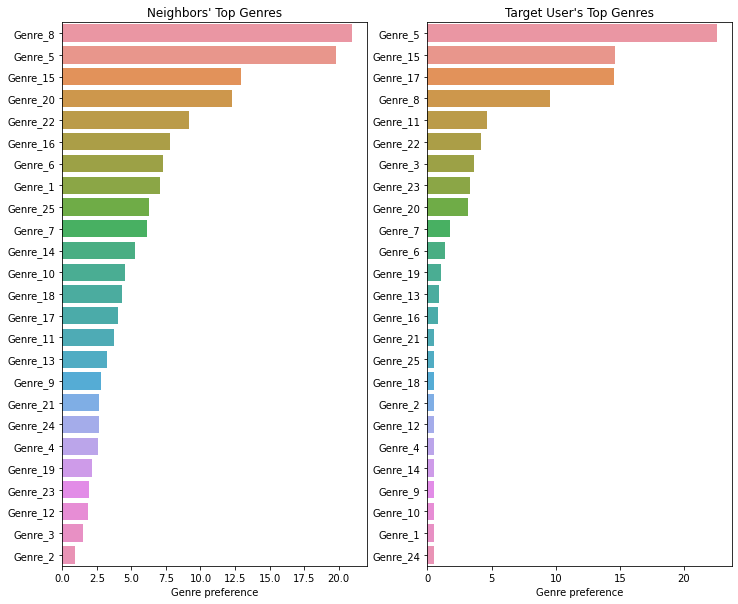

In [11]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [12]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
48,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.6%,https://www.goodreads.com/book/show/20934376-s...
47,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.6%,https://www.goodreads.com/book/show/18781068-s...
80,War's Unwomanly Face,4.52,1182.0,1988,1.6%,https://www.goodreads.com/book/show/4025275-wa...
33,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.6%,https://www.goodreads.com/book/show/24611623-i...
6,Assata: An Autobiography,4.47,11057.0,1999,1.6%,https://www.goodreads.com/book/show/100322.Assata
51,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.6%,https://www.goodreads.com/book/show/27220736-s...
5,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,1.6%,https://www.goodreads.com/book/show/17836520-a...
37,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,1.6%,https://www.goodreads.com/book/show/18371021-m...
7,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0,2014,1.6%,https://www.goodreads.com/book/show/18687079-a...
18,Daytripper,4.31,18265.0,2011,1.6%,https://www.goodreads.com/book/show/8477057-da...


In [13]:
# Highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
48,Secrets of a Side Bitch 3,4.58,1181.0,2014,https://www.goodreads.com/book/show/20934376-s...
47,Secrets of a Side Bitch 2,4.54,1419.0,2013,https://www.goodreads.com/book/show/18781068-s...
80,War's Unwomanly Face,4.52,1182.0,1988,https://www.goodreads.com/book/show/4025275-wa...
33,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
6,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
51,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
5,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,2015,https://www.goodreads.com/book/show/17836520-a...
37,My Journey : Transforming Dreams into Actions,4.35,1743.0,2013,https://www.goodreads.com/book/show/18371021-m...
7,"Avatar: The Last Airbender: The Rift, Part 1 (...",4.33,10667.0,2014,https://www.goodreads.com/book/show/18687079-a...
18,Daytripper,4.31,18265.0,2011,https://www.goodreads.com/book/show/8477057-da...


In [14]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
19,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
8,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
20,Why I Am An Atheist: An Autobiographical Disco...,4.45,866.0,https://www.goodreads.com/book/show/1389596.Wh...
12,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
6,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
16,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
10,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
18,Time Stops at Shamli and Other Stories,4.11,1091.0,https://www.goodreads.com/book/show/475218.Tim...
11,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0,https://www.goodreads.com/book/show/3930572-sc...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
11,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
9,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...
2,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
4,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
12,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
0,Alice in Wonderland,4.03,346530.0,https://www.goodreads.com/book/show/13023.Alic...
13,Voyage of the Beagle,4.03,4417.0,https://www.goodreads.com/book/show/183645.Voy...
8,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
3,"Go Down, Moses",3.93,7562.0,https://www.goodreads.com/book/show/17726.Go_D...
7,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
3,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
12,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
19,Totto-chan: The Little Girl at the Window,4.30,14456.0,https://www.goodreads.com/book/show/328802.Tot...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
1,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
17,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
15,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
16,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
11,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...
4,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,https://www.goodreads.com/book/show/1202.Freak...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url


_____



## Part 2 - User:Item Collaborative Filtering with Matrix Factorization

#### 2.1 - Matrix Factorization with SVD

In [15]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(2000, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_21750/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_21750/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [16]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [17]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [18]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

In [19]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)

# Write to excel
path = wd + "/data/book_recs.xlsx"
if os.path.isfile(path):
    with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
else:
    with pd.ExcelWriter(path) as writer:
        top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
            .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
writer.close

top_preds.query("avg_rating > 3.9").head(20)    

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
3,0.470757,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,5.0,https://www.goodreads.com/book/show/17851885-i...
4,0.401625,Bad Feminist,3.91,43988.0,2014,16.0,https://www.goodreads.com/book/show/18813642-b...
6,0.332856,Wonder (Wonder #1),4.43,255461.0,2012,16.0,https://www.goodreads.com/book/show/11387515-w...
8,0.318639,Night (The Night Trilogy #1),4.30,708754.0,1958,20.0,https://www.goodreads.com/book/show/1617.Night
9,0.301181,Evicted: Poverty and Profit in the American City,4.47,18205.0,2016,20.0,https://www.goodreads.com/book/show/25852784-e...
11,0.279186,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,2010,5.0,https://www.goodreads.com/book/show/6792458-th...
12,0.277804,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.0,https://www.goodreads.com/book/show/13453029-w...
13,0.242439,A Fighting Chance,4.17,8740.0,2014,5.0,https://www.goodreads.com/book/show/18779662-a...
16,0.220036,All the Ugly and Wonderful Things,4.10,35002.0,2016,23.0,https://www.goodreads.com/book/show/26114135-a...
20,0.192199,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,16.0,https://www.goodreads.com/book/show/30253864-t...


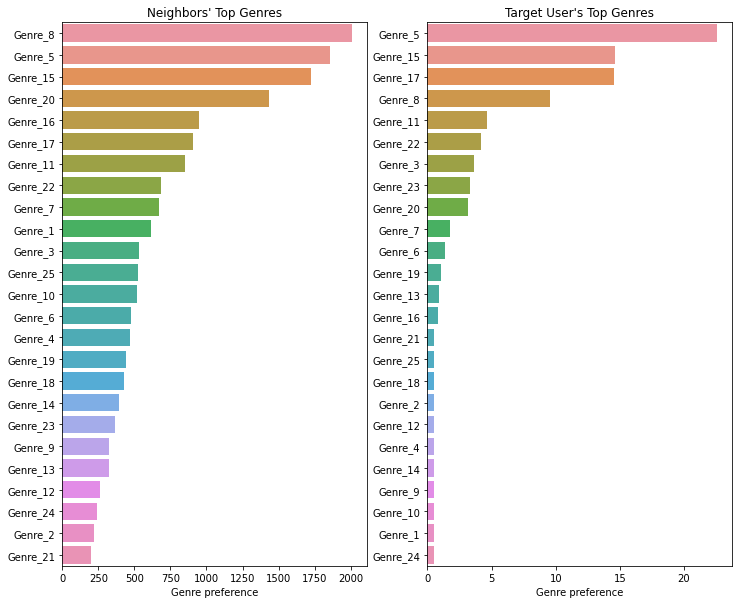

In [20]:
# Show top genres
plot_top_genres(large_neighborhood_ratings, target_user_ratings)

In [21]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(large_neighborhood_ratings, 50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
1509,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,2.8%,https://www.goodreads.com/book/show/17851885-i...
384,Bad Feminist,3.91,43988.0,2014,2.5%,https://www.goodreads.com/book/show/18813642-b...
4443,Wonder (Wonder #1),4.43,255461.0,2012,2.2%,https://www.goodreads.com/book/show/11387515-w...
2068,Night (The Night Trilogy #1),4.30,708754.0,1958,1.7%,https://www.goodreads.com/book/show/1617.Night
3325,The Gunslinger,3.98,346978.0,1982,1.6%,https://www.goodreads.com/book/show/43615.The_...
237,All the Ugly and Wonderful Things,4.10,35002.0,2016,1.4%,https://www.goodreads.com/book/show/26114135-a...
3298,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,1.4%,https://www.goodreads.com/book/show/15819028-t...
2811,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,1.4%,https://www.goodreads.com/book/show/30253864-t...
3658,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.3%,https://www.goodreads.com/book/show/5043.The_P...
4450,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.3%,https://www.goodreads.com/book/show/13453029-w...


In [22]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(large_neighborhood_ratings, 50, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
3739,The Revenge of the Baby-Sat,4.71,11626.0,1991,https://www.goodreads.com/book/show/121792.The...
2485,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
4509,Yukon Ho!,4.70,8983.0,1989,https://www.goodreads.com/book/show/70491.Yuko...
3123,The Days Are Just Packed: A Calvin and Hobbes ...,4.69,19336.0,1993,https://www.goodreads.com/book/show/24818.The_...
3997,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,https://www.goodreads.com/book/show/9329354-th...
1514,I Dissent: Ruth Bader Ginsburg Makes Her Mark,4.67,1665.0,2016,https://www.goodreads.com/book/show/28210996-i...
3484,The Life and Times of Scrooge McDuck,4.67,2047.0,2005,https://www.goodreads.com/book/show/5309.The_L...
3362,The Holy Bible: English Standard Version,4.66,18613.0,2007,https://www.goodreads.com/book/show/5883777-th...
1759,Letter from the Birmingham Jail,4.64,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...
3194,The Essential Calvin and Hobbes: A Calvin and ...,4.64,95116.0,1988,https://www.goodreads.com/book/show/43070.The_...


In [23]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    large_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.15, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
11,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
13,A Fighting Chance,4.17,8740.0,https://www.goodreads.com/book/show/18779662-a...
28,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
31,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
42,Digital Gold: Bitcoin and the Inside Story of ...,4.16,1674.0,https://www.goodreads.com/book/show/23546676-d...
63,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
83,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
86,My Promised Land: The Triumph and Tragedy of I...,4.22,4226.0,https://www.goodreads.com/book/show/15798334-m...
105,The Shadow of the Sun,4.37,5153.0,https://www.goodreads.com/book/show/9541.The_S...
116,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
24,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
101,Palestine,4.20,10082.0,https://www.goodreads.com/book/show/769712.Pal...
225,The Gene: An Intimate History,4.36,9874.0,https://www.goodreads.com/book/show/27276428-t...
331,Teaching My Mother How to Give Birth,4.38,7830.0,https://www.goodreads.com/book/show/13376363-t...
379,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0,https://www.goodreads.com/book/show/28505023-t...
389,"The Autobiography of Martin Luther King, Jr.",4.32,11478.0,https://www.goodreads.com/book/show/42547.The_...
481,The Essential Kierkegaard,4.16,1573.0,https://www.goodreads.com/book/show/24964.The_...
454,"The Big Picture: On the Origins of Life, Meani...",4.18,2208.0,https://www.goodreads.com/book/show/26150770-t...
550,Fermat's Enigma: The Epic Quest to Solve the W...,4.22,16113.0,https://www.goodreads.com/book/show/38412.Ferm...
586,"The Intellectual Life: Its Spirit, Conditions,...",4.37,574.0,https://www.goodreads.com/book/show/549384.The...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
123,Spillover: Animal Infections and the Next Huma...,4.27,2586.0,https://www.goodreads.com/book/show/13637215-s...
208,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
216,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
245,"First Shift: Legacy (Shift, #1)",4.21,15301.0,https://www.goodreads.com/book/show/13603717-f...
362,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
557,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
735,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...
743,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
750,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
1023,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
48,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
61,NeuroTribes: The Legacy of Autism and the Futu...,4.29,3998.0,https://www.goodreads.com/book/show/22514020-n...
76,Word by Word: The Secret Life of Dictionaries,4.21,1422.0,https://www.goodreads.com/book/show/30781490-w...
78,"Saving Capitalism: For the Many, Not the Few",4.26,1818.0,https://www.goodreads.com/book/show/24338377-s...
93,"A Path Appears: Transforming Lives, Creating O...",4.21,1969.0,https://www.goodreads.com/book/show/20342518-a...
224,The Gifts of Imperfection: Let Go of Who You T...,4.17,49306.0,https://www.goodreads.com/book/show/7015403-th...
349,The Tale of the Dueling Neurosurgeons: The His...,4.19,5734.0,https://www.goodreads.com/book/show/18774002-t...
380,The Dictator's Handbook: Why Bad Behavior is A...,4.27,2497.0,https://www.goodreads.com/book/show/11612989-t...
381,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
398,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
57,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
945,The Essential Dykes to Watch Out For,4.36,6979.0,https://www.goodreads.com/book/show/3189884-th...
1215,The Refrigerator Monologues,4.21,894.0,https://www.goodreads.com/book/show/32714267-t...
1336,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1532,CivilWarLand in Bad Decline,4.22,1615.0,https://www.goodreads.com/book/show/331688.Civ...
1600,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
1684,Cinema Panopticum,4.16,784.0,https://www.goodreads.com/book/show/634790.Cin...
2183,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
2186,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
2682,What Was I Scared Of?,4.20,2493.0,https://www.goodreads.com/book/show/644346.Wha...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
242,"The Last Unicorn (The Last Unicorn, #1)",4.18,77163.0,https://www.goodreads.com/book/show/29127.The_...
503,The False Prince (The Ascendance Trilogy #1),4.23,51292.0,https://www.goodreads.com/book/show/12432220-t...
623,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,https://www.goodreads.com/book/show/26863057-a...
754,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0,https://www.goodreads.com/book/show/31140332-t...
763,Rogue One: A Star Wars Story,4.17,3228.0,https://www.goodreads.com/book/show/30008713-r...
837,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
1031,Lost Boy: The True Story of Captain Hook,4.20,1420.0,https://www.goodreads.com/book/show/32828538-l...
1419,"Scythe (Arc of a Scythe, #1)",4.30,13000.0,https://www.goodreads.com/book/show/28954189-s...
1694,Golden Son,4.45,942.0,https://www.goodreads.com/book/show/25430565-g...
1805,"Sweet Tooth, Volume 6: Wild Game",4.32,3107.0,https://www.goodreads.com/book/show/17137619-s...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
707,"Harry Potter: The Prequel (Harry Potter, #0.5)",4.22,13267.0,https://www.goodreads.com/book/show/8933944-ha...
746,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
749,The Julian Chapter,4.32,11380.0,https://www.goodreads.com/book/show/20878809-t...
764,The Kite Runner: Graphic Novel,4.25,6466.0,https://www.goodreads.com/book/show/11296523-t...
859,2016 on Goodreads,4.25,1167.0,https://www.goodreads.com/book/show/33232571-2...
954,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0,https://www.goodreads.com/book/show/3710603-y
964,"Batman, Volume 3: Death of the Family",4.33,8461.0,https://www.goodreads.com/book/show/17671913-b...
969,The Dark Tower,4.27,96576.0,https://www.goodreads.com/book/show/5091.The_D...
1037,"Ms. Marvel, #1: Meta Morphosis",4.32,4702.0,https://www.goodreads.com/book/show/18757876-m...
1154,"Heartbreak Soup (Luba and Palomar, #1)",4.35,1394.0,https://www.goodreads.com/book/show/405552.Hea...


_____

Genre 23: ['agent', 'team', 'mission', 'job', 'dead', 'terrorist', 'zombie', 'government', 'secret', 'drug']


,title,avg_rating,ratings_count,url
431,The Plot to Hack America: How Putin’s Cyberspi...,4.17,444.0,https://www.goodreads.com/book/show/32202585-t...
1300,"Much Obliged, Jeeves",4.24,472.0,https://www.goodreads.com/book/show/16394.Much...
1673,The Legend of Korra: Turf Wars Part One (Turf ...,4.35,1946.0,https://www.goodreads.com/book/show/33161035-t...
1953,Daredevil: Born Again,4.31,597.0,https://www.goodreads.com/book/show/6929380-da...
2108,Never Split the Difference: Negotiating As If ...,4.49,3314.0,https://www.goodreads.com/book/show/26156469-n...
3514,"Lucifer, Book One (Lucifer, #1)",4.24,1708.0,https://www.goodreads.com/book/show/17137616-l...
3970,The Smallest Dragonboy,4.27,4232.0,https://www.goodreads.com/book/show/2386345.Th...
4292,American Pain: How a Young Felon and His Ring ...,4.23,692.0,https://www.goodreads.com/book/show/25992990-a...
4673,Richard Stark’s Parker: The Score,4.28,1919.0,https://www.goodreads.com/book/show/14539948-r...
4915,Shadows for Silence in the Forests of Hell,4.16,5683.0,https://www.goodreads.com/book/show/21411388-s...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
8,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
9,Evicted: Poverty and Profit in the American City,4.47,18205.0,https://www.goodreads.com/book/show/25852784-e...
204,Daytripper,4.31,18265.0,https://www.goodreads.com/book/show/8477057-da...
565,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...
614,"Instrumental: A Memoir of Madness, Medication ...",4.26,1796.0,https://www.goodreads.com/book/show/21896497-i...
702,The Heart of a Woman,4.19,16156.0,https://www.goodreads.com/book/show/5160.The_H...
737,Swami and Friends,4.21,8253.0,https://www.goodreads.com/book/show/732482.Swa...
788,Dog Medicine,4.25,1435.0,https://www.goodreads.com/book/show/25799992-d...
878,The Chronology of Water,4.20,4956.0,https://www.goodreads.com/book/show/9214995-th...
948,I Know Why the Caged Bird Sings (Maya Angelou'...,4.19,2146.0,https://www.goodreads.com/book/show/215575.I_K...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
26,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
396,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,4.59,92172.0,https://www.goodreads.com/book/show/30.J_R_R_T...
576,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,https://www.goodreads.com/book/show/100915.The...
599,"Niccolò Rising (The House of Niccolò, #1)",4.27,2897.0,https://www.goodreads.com/book/show/112078.Nic...
698,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0,https://www.goodreads.com/book/show/15177.Brid...
832,The Forest Unseen: A Year’s Watch in Nature,4.19,1576.0,https://www.goodreads.com/book/show/11797368-t...
868,Jaya: An Illustrated Retelling of the Mahabharata,4.20,9857.0,https://www.goodreads.com/book/show/9864913-jaya
892,Echo,4.36,16126.0,https://www.goodreads.com/book/show/22749539-echo
966,Interstellar Cinderella,4.22,2024.0,https://www.goodreads.com/book/show/22875394-i...
1209,The Complete Grimm's Fairy Tales,4.31,117324.0,https://www.goodreads.com/book/show/22917.The_...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [64]:
R = R.toarray()

In [69]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0005, beta=0.05, decay=0.95, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm. Useful explanation
    of the math here: 
    http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/#source-code

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every 1k steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): # Only do every 1k steps
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.6f}") 
            
            # Set learning rate to decay until 0.00002
            if lr > 0.00002:            
                # lr = (1 / (1 + decay * (step))) * lr 
                lr = lr * decay
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [70]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(R, k_components=15, steps=20000, verbose=1)

Step: 1, error: 44788.44, lr: 0.000475
Step: 1000, error: 30955.85, lr: 0.000020


KeyboardInterrupt: 

In [ ]:
# Make dataframe from predictions and indices
df_preds = pd.DataFrame(preds, columns=neighbor_book_index, index=neighbor_index)\
                .reset_index()

# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(
                    df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                    on="book_id"
                )\
                .drop(columns=["index"])

# View preds on actually read books
target_books_preds = top_preds[top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]\
                        .drop(["book_index"], axis=1)
target_books_preds = pd.merge(target_books_preds, target_user_ratings[["book_id", "user_rating"]], on="book_id")
target_books_preds["diff"] = target_books_preds["predicted_rating"] - target_books_preds["user_rating"]
print("Predictions on Actually Read Books")
display(target_books_preds[["title", "predicted_rating", "user_rating", "diff"]])

# Filter out already read books to get top preds
print("___________\n")
print("Predictions on Unread Books")
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
display(top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
        .query("avg_rating > 3.9 & ratings_count > 400").head(20)
    )

Predictions on Actually Read Books


,title,predicted_rating,user_rating,diff
0,Sapiens: A Brief History of Humankind,4.982178,5.0,-0.017822
1,Matterhorn,4.982161,5.0,-0.017839
2,Miles: The Autobiography,4.982145,5.0,-0.017855
3,Steve Jobs,4.982105,5.0,-0.017895
4,"The Stone Sky (The Broken Earth, #3)",4.982066,5.0,-0.017934
...,...,...,...,...
90,The Populist Explosion: How the Great Recessio...,1.993002,2.0,-0.006998
91,"Vicious (Villains, #1)",1.992964,2.0,-0.007036
92,The One Thing: The Surprisingly Simple Truth B...,1.992923,2.0,-0.007077
93,"Casino Royale (James Bond, #1)",0.997687,1.0,-0.002313


___________

Predictions on Unread Books


,title,avg_rating,predicted_rating,ratings_count,year,url
1,Word by Word: The Secret Life of Dictionaries,4.21,7.303564,1422.0,2017,https://www.goodreads.com/book/show/30781490-w...
2,The Philosophy Book,4.16,7.275574,1485.0,2011,https://www.goodreads.com/book/show/8493026-th...
4,Crictor,4.08,7.038018,1338.0,1983,https://www.goodreads.com/book/show/1097582.Cr...
5,"Planetary, Volume 4: Spacetime Archaeology",4.46,7.023406,4114.0,2010,https://www.goodreads.com/book/show/5210326-pl...
7,The Last Jew of Treblinka,4.22,6.987692,1869.0,2009,https://www.goodreads.com/book/show/8467720-th...
9,Miracles Happen,3.97,6.930668,734.0,1981,https://www.goodreads.com/book/show/1529719.Mi...
12,The Wrecking Crew: How Conservatives Rule,3.96,6.860253,1789.0,2008,https://www.goodreads.com/book/show/3351062-th...
18,Models: Attract Women Through Honesty,4.44,6.810939,3362.0,2011,https://www.goodreads.com/book/show/12633800-m...
20,The Witness for the Prosecution: A Short Story,4.19,6.808807,1024.0,1983,https://www.goodreads.com/book/show/18901372-t...
21,"Barefoot Gen, Volume One: A Cartoon Story of H...",4.21,6.755496,4597.0,2004,https://www.goodreads.com/book/show/116223.Bar...


In [ ]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    large_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.15, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
40,The Radium Girls: The Dark Story of America's ...,4.26,6453.0,https://www.goodreads.com/book/show/31409135-t...
79,How Dare the Sun Rise: Memoirs of a War Child,4.28,451.0,https://www.goodreads.com/book/show/31706524-h...
85,Hanns and Rudolf: The True Story of the German...,4.27,1171.0,https://www.goodreads.com/book/show/16130338-h...
144,No Ordinary Time: Franklin and Eleanor Rooseve...,4.19,28368.0,https://www.goodreads.com/book/show/18728.No_O...
154,"I, Partridge: We Need to Talk About Alan",4.19,4856.0,https://www.goodreads.com/book/show/12363948-i...
178,An Imperfect Offering: Humanitarian Action in ...,4.30,1430.0,https://www.goodreads.com/book/show/2140743.An...
192,Give Us the Ballot: The Modern Struggle for Vo...,4.42,720.0,https://www.goodreads.com/book/show/22929518-g...
201,An Era of Darkness: The British Empire in India,4.23,875.0,https://www.goodreads.com/book/show/32618967-a...
235,Righteous Dopefiend,4.42,802.0,https://www.goodreads.com/book/show/6614135-ri...
283,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
2,The Philosophy Book,4.16,1485.0,https://www.goodreads.com/book/show/8493026-th...
60,Alchemy of Race and Rights,4.27,570.0,https://www.goodreads.com/book/show/221700.Alc...
96,The Orthodox Heretic And Other Impossible Tales,4.18,899.0,https://www.goodreads.com/book/show/4956232-th...
103,Thelonious Monk: The Life and Times of an Amer...,4.24,1361.0,https://www.goodreads.com/book/show/2549392.Th...
162,The Fire This Time: A New Generation Speaks ab...,4.35,2309.0,https://www.goodreads.com/book/show/28505023-t...
193,"Sifting Through the Madness for the Word, the ...",4.24,1908.0,https://www.goodreads.com/book/show/50469.Sift...
229,Wrapped in Rainbows: The Life of Zora Neale Hu...,4.26,780.0,https://www.goodreads.com/book/show/38466.Wrap...
254,Labyrinths: Selected Stories & Other Writings,4.46,1284.0,https://www.goodreads.com/book/show/336116.Lab...
308,Felicity,4.27,2390.0,https://www.goodreads.com/book/show/24611522-f...
321,Sixth of the Dusk,4.21,8122.0,https://www.goodreads.com/book/show/23397921-s...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
5,"Planetary, Volume 4: Spacetime Archaeology",4.46,4114.0,https://www.goodreads.com/book/show/5210326-pl...
39,Astonishing X-Men Ultimate Collection Volume 1,4.37,559.0,https://www.goodreads.com/book/show/12579399-a...
95,Princeless: Raven the Pirate Princess Book 1: ...,4.34,578.0,https://www.goodreads.com/book/show/26527730-p...
147,"Wild Seed (Patternmaster, #1)",4.22,421.0,https://www.goodreads.com/book/show/15769843-w...
231,There Will Come Soft Rains,4.23,2554.0,https://www.goodreads.com/book/show/2260460.Th...
268,"Rosie Revere, Engineer",4.54,4789.0,https://www.goodreads.com/book/show/17290220-r...
506,Miracle in the Andes,4.22,11354.0,https://www.goodreads.com/book/show/454236.Mir...
674,Lizard Music,4.19,1361.0,https://www.goodreads.com/book/show/63321.Liza...
675,Voodoo Plague (Book 1),4.18,829.0,https://www.goodreads.com/book/show/19521430-v...
1026,Halo: The Fall of Reach,4.26,14823.0,https://www.goodreads.com/book/show/60229.Halo


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
1,Word by Word: The Secret Life of Dictionaries,4.21,1422.0,https://www.goodreads.com/book/show/30781490-w...
18,Models: Attract Women Through Honesty,4.44,3362.0,https://www.goodreads.com/book/show/12633800-m...
41,Tools of Titans,4.27,735.0,https://www.goodreads.com/book/show/30820956-t...
62,Harry Potter Schoolbooks Box Set: Two Classic ...,4.40,10914.0,https://www.goodreads.com/book/show/2002.Harry...
68,The Power of Vulnerability: Teachings on Authe...,4.57,591.0,https://www.goodreads.com/book/show/15894633-t...
73,The One-Straw Revolution,4.38,2601.0,https://www.goodreads.com/book/show/976905.The...
83,Strength to Love,4.59,1481.0,https://www.goodreads.com/book/show/52101.Stre...
92,The Power of Vulnerability: Teachings of Authe...,4.57,3778.0,https://www.goodreads.com/book/show/23500254-t...
126,HTML and CSS: Design and Build Websites,4.35,2718.0,https://www.goodreads.com/book/show/10361330-h...
153,MAKE: Electronics: Learning Through Discovery,4.23,701.0,https://www.goodreads.com/book/show/6945716-make


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
36,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
46,Incidences,4.32,658.0,https://www.goodreads.com/book/show/685172.Inc...
65,Out on the Wire: Uncovering the Secrets of Rad...,4.19,627.0,https://www.goodreads.com/book/show/23742836-o...
150,The Picnic and Suchlike Pandemonium,4.21,569.0,https://www.goodreads.com/book/show/111791.The...
311,Digging Up Mother: A Love Story,4.30,882.0,https://www.goodreads.com/book/show/28589336-d...
430,The Fortune of War,4.38,8195.0,https://www.goodreads.com/book/show/77426.The_...
465,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
1015,CivilWarLand in Bad Decline,4.22,1615.0,https://www.goodreads.com/book/show/331688.Civ...
1052,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
1070,The Complete Stories of Truman Capote,4.21,3496.0,https://www.goodreads.com/book/show/2281.The_C...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
31,Blackwing (Ravens' Mark #1),4.24,401.0,https://www.goodreads.com/book/show/33916060-b...
77,The Shepherd's Crown,4.35,1081.0,https://www.goodreads.com/book/show/25398409-t...
89,"My Soul to Keep (African Immortals, #1)",4.21,3117.0,https://www.goodreads.com/book/show/41536.My_S...
140,"Mara, Daughter of the Nile",4.23,7903.0,https://www.goodreads.com/book/show/406186.Mar...
190,Gunner Girls and Fighter Boys,4.23,586.0,https://www.goodreads.com/book/show/26091600-g...
211,"The Broken God (A Requiem for Homo Sapiens, #1)",4.24,528.0,https://www.goodreads.com/book/show/2031004.Th...
538,The Dark Tower: The Gunslinger - The Man in Black,4.28,1446.0,https://www.goodreads.com/book/show/15984307-t...
575,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
616,"Dawn of Wonder (The Wakening, #1)",4.35,13351.0,https://www.goodreads.com/book/show/25451852-d...
795,"The Vision, Volume 1: Little Worse Than A Man",4.26,5053.0,https://www.goodreads.com/book/show/27163019-t...


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
274,2016 on Goodreads,4.25,1167.0,https://www.goodreads.com/book/show/33232571-2...
289,The Last Answer,4.17,1150.0,https://www.goodreads.com/book/show/15755066-t...
318,The Life and Times of Scrooge McDuck,4.67,2047.0,https://www.goodreads.com/book/show/5309.The_L...
346,Avatar: The Last Airbender (The Art of the Ani...,4.50,15507.0,https://www.goodreads.com/book/show/7642606-av...
535,The Collected Stories of Philip K. Dick 5: The...,4.25,1146.0,https://www.goodreads.com/book/show/22585.The_...
719,The Clown of God,4.21,2353.0,https://www.goodreads.com/book/show/69086.The_...
774,"Preacher, Volume 7: Salvation",4.30,14140.0,https://www.goodreads.com/book/show/102954.Pre...
962,"Ms. Marvel, #1: Meta Morphosis",4.32,4702.0,https://www.goodreads.com/book/show/18757876-m...
1204,The Mysteries of Harris Burdick,4.53,652.0,https://www.goodreads.com/book/show/402114.The...
1305,The Light Bearer,4.20,889.0,https://www.goodreads.com/book/show/479519.The...


_____

Genre 23: ['agent', 'team', 'mission', 'job', 'dead', 'terrorist', 'zombie', 'government', 'secret', 'drug']


,title,avg_rating,ratings_count,url
55,The Legend of Korra: Turf Wars Part One (Turf ...,4.35,1946.0,https://www.goodreads.com/book/show/33161035-t...
624,Daredevil: Born Again,4.31,597.0,https://www.goodreads.com/book/show/6929380-da...
691,The Private Eye #1,4.24,512.0,https://www.goodreads.com/book/show/17662660-t...
1165,"Attack on Titan, Volume 15",4.40,1081.0,https://www.goodreads.com/book/show/22716573-a...
2734,"Much Obliged, Jeeves",4.24,472.0,https://www.goodreads.com/book/show/16394.Much...
3028,"Lucifer, Book One (Lucifer, #1)",4.24,1708.0,https://www.goodreads.com/book/show/17137616-l...
3288,"Rurouni Kenshin, Volume 26",4.38,1481.0,https://www.goodreads.com/book/show/294971.Rur...
4662,"The Cartel (The Cartel, #1)",4.58,5703.0,https://www.goodreads.com/book/show/5953477-th...
5430,The Smallest Dragonboy,4.27,4232.0,https://www.goodreads.com/book/show/2386345.Th...
6154,Shadows for Silence in the Forests of Hell,4.16,5683.0,https://www.goodreads.com/book/show/21411388-s...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
34,The Madness Vase: By Andrea Gibson,4.56,1631.0,https://www.goodreads.com/book/show/12193298-t...
205,Buck: A Memoir,4.19,1205.0,https://www.goodreads.com/book/show/16169867-buck
312,Lucky Boy,4.17,3563.0,https://www.goodreads.com/book/show/29430055-l...
359,A Little Life,4.28,762.0,https://www.goodreads.com/book/show/29408433-a...
367,North of Normal: A Memoir of My Wilderness Chi...,4.16,3428.0,https://www.goodreads.com/book/show/18635097-n...
374,Your Blues Ain't Like Mine,4.19,6311.0,https://www.goodreads.com/book/show/205368.You...
409,After Auschwitz,4.29,467.0,https://www.goodreads.com/book/show/17828703-a...
497,All But My Life: A Memoir,4.28,14073.0,https://www.goodreads.com/book/show/163363.All...
516,The Center Cannot Hold: My Journey Through Mad...,4.23,500.0,https://www.goodreads.com/book/show/2181710.Th...
530,It's. Nice. Outside.,4.24,1031.0,https://www.goodreads.com/book/show/23847985-i...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
66,The Drawing of the Three,4.23,451.0,https://www.goodreads.com/book/show/29430675-t...
602,Grounded: The Adventures of Rapunzel (Tyme #1),4.16,1438.0,https://www.goodreads.com/book/show/23399287-g...
907,The Language of Thorns: Midnight Tales and Dan...,4.53,4200.0,https://www.goodreads.com/book/show/34076952-t...
917,Interstellar Cinderella,4.22,2024.0,https://www.goodreads.com/book/show/22875394-i...
969,Uncle Dynamite,4.28,518.0,https://www.goodreads.com/book/show/16241184-u...
1423,Beauty and the Beast,4.34,5462.0,https://www.goodreads.com/book/show/14116.Beau...
1603,"Out from Boneville (Bone, #1)",4.16,63254.0,https://www.goodreads.com/book/show/106134.Out...
1635,Mufaro's Beautiful Daughters: An African Tale,4.32,16896.0,https://www.goodreads.com/book/show/845403.Muf...
1742,The First Rumpole Omnibus,4.30,1278.0,https://www.goodreads.com/book/show/54383.The_...
1744,"The Physician (Cole Family Trilogy, #1)",4.35,19716.0,https://www.goodreads.com/book/show/4692.The_P...


_____

